In [1]:
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize,least_squares,Bounds
from scipy.special import gamma
import matplotlib.cm as cm
from Boruvka_Mod import Graph

In [2]:
# Parameters
v0=8.0
nwind = 33
wind=np.arange(254,287)
#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))
model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))
ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)
Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines
Vc = 4.0 #Cut-in Velocity
Vr = 15.0 #Rated Velocity
Vf = 25.0 #Cut-off Velocity
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)
#interpolation parameters
dvel=1.5
dang=5.

In [3]:
v=np.loadtxt('hornsrev_data_all.txt')

vxref=v[:,3]
vyref=v[:,4]
angles=v[:,0]
vmean=np.sqrt(np.square(vxref)+np.square(vyref))
vmean=pd.DataFrame(vmean)
vref=pd.DataFrame()
vmean['angle']=angles
vref=vref.append(vmean)
vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0]
#vref.iat[5,0]
#vref.groupby('angle')

6.512913707119303

-2950.0 -1875.0
[array([  676.5,  2969.5, -2553.5,  1211.5,  2757.5,  2283.5,   626.5,
       -1934.5, -1500.5, -2342.5,   229.5, -2889.5,   599.5,  1647.5,
        1175.5, -2134.5, -2605.5, -2969.5,   238.5, -2375.5, -2064.5,
         569.5,  1949.5,   666.5,  2302.5, -2451.5,   835.5, -1514.5,
       -2523.5,  1381.5,  1750.5,  2680.5,  -333.5, -1805.5, -1065.5,
       -1401.5,  2560.5,  1778.5, -2004.5,  2959.5]), array([  -44., -1306., -1688., -1193.,  1284., -1108.,  -660.,  -585.,
        1875.,  -863.,   962., -1400.,  -513.,  1733.,  1558.,    -8.,
       -1185.,   855.,   918.,  1041.,   992.,   626.,  -110.,   333.,
         364.,   577.,  1879.,  -844.,  1005., -1159., -1050.,  -679.,
       -1330.,   580., -1879., -1143.,  1150.,  1011.,  1191.,   741.])]


475.27886550950274

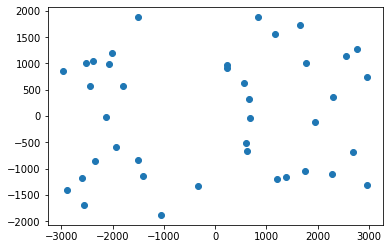

In [4]:
coords_in = np.loadtxt('start_coords.txt')###
print(min(coords_in[:,0]), min(coords_in[:,1]))
xmin = min(coords_in[:,0])
ymin = min(coords_in[:,1])

xzero = (max(coords_in[:,0])-xmin)/2
yzero = (max(coords_in[:,1])-ymin)/2
#print(xzero, yzero)

coords_x=coords_in[:,0]-xzero-xmin
coords_y=coords_in[:,1]-yzero-ymin
coords=[coords_x,coords_y]
print (coords)
coords=np.array(coords).T
nturb=np.shape(coords)[0]
plt.scatter(coords[:,0], coords[:,1])

#Arrays for pairwise distances and angles
#Angle 0: x directıon. Angle pi/2: y directıon
distance=np.zeros((nturb,nturb))
angle=np.zeros((nturb,nturb))
for i in range(0,nturb):
    distance[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1]))
    angle[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0])
#Rotate angles so that north=0 and convert to degrees
angle=-np.rad2deg(angle)+270
angle[0,1]

#Rotating angles to wind direction
windangle=5 #degrees
rotangles=np.mod(angle-windangle+180,360)-180

(np.sort(distance))[0,2]

In [5]:
import pandas as pd
data = pd.read_csv ('Directiondata.csv')
print (data)

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


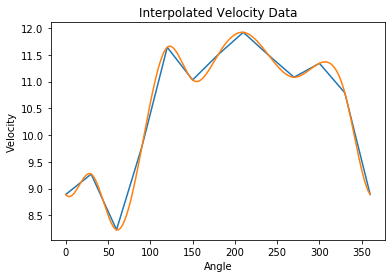

In [6]:
#interpolate 'velcoity'
x = data['Angle']
y = data['Velocity']
from scipy.interpolate import CubicSpline as SP
import matplotlib.pyplot as plt
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()

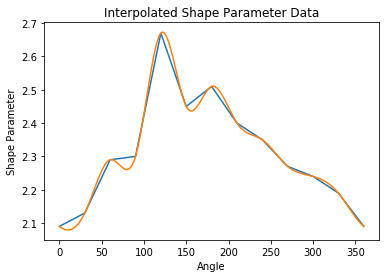

In [7]:
#interpolate 'c'
x = data['Angle']
y = data['c']
from scipy.interpolate import CubicSpline as SP
import matplotlib.pyplot as plt
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

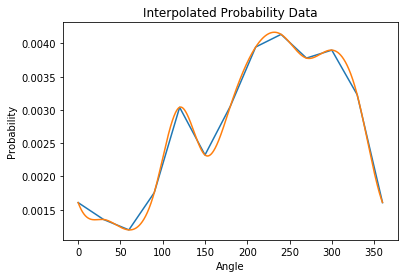

In [8]:
#interpolate 'frecuency'
x = data['Angle']
y = data['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree
from scipy.interpolate import CubicSpline as SP
import matplotlib.pyplot as plt
windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()

In [9]:
#Simple Attenuation fn
def att(dist, ang, model):
    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    #radial
    radial=np.exp(-np.square(dist/model[2]))
    penalty=np.exp(-np.square(dist/200))
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty

In [10]:
print(np.sort(angle.flatten()))

[ 90.12008529  90.32940078  90.41378033 ... 449.73392244 449.90189088
 449.92008962]


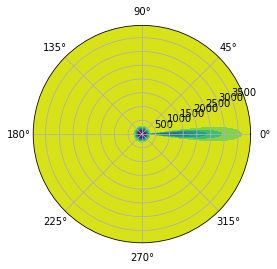

0.580003843


In [11]:
azimuths = np.radians(np.linspace(0, 360, 360))
zeniths = np.arange(0, 4000, 50)

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model)

#print(values)
#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

In [12]:
print(theta,np.mod(np.deg2rad(theta)+np.pi,np.pi*2)-np.pi)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.01750191 0.01750191 0.01750191 ... 0.01750191 0.01750191 0.01750191]
 [0.03500382 0.03500382 0.03500382 ... 0.03500382 0.03500382 0.03500382]
 ...
 [6.24818149 6.24818149 6.24818149 ... 6.24818149 6.24818149 6.24818149]
 [6.2656834  6.2656834  6.2656834  ... 6.2656834  6.2656834  6.2656834 ]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00030547 0.00030547 0.00030547 ... 0.00030547 0.00030547 0.00030547]
 [0.00061093 0.00061093 0.00061093 ... 0.00061093 0.00061093 0.00061093]
 ...
 [0.10905134 0.10905134 0.10905134 ... 0.10905134 0.10905134 0.10905134]
 [0.10935681 0.10935681 0.10935681 ... 0.10935681 0.10935681 0.10935681]
 [0.10966227 0.10966227 0.10966227 ... 0.10966227 0.10966227 0.10966227]]


In [13]:
r=np.arange

In [14]:
ind=np.zeros((8,10))
for i in range(0,8):
    for j in range(0,10):
        ind[i,j]=i+8*j
ind=ind.astype(int)
ind

array([[ 0,  8, 16, 24, 32, 40, 48, 56, 64, 72],
       [ 1,  9, 17, 25, 33, 41, 49, 57, 65, 73],
       [ 2, 10, 18, 26, 34, 42, 50, 58, 66, 74],
       [ 3, 11, 19, 27, 35, 43, 51, 59, 67, 75],
       [ 4, 12, 20, 28, 36, 44, 52, 60, 68, 76],
       [ 5, 13, 21, 29, 37, 45, 53, 61, 69, 77],
       [ 6, 14, 22, 30, 38, 46, 54, 62, 70, 78],
       [ 7, 15, 23, 31, 39, 47, 55, 63, 71, 79]])

In [15]:
i=0
j=4
print('Turbine {} x {} y {}'.format(i,coords[i,0],coords[i,1]))
print('Turbine {} x {} y {}'.format(j,coords[j,0],coords[j,1]))
print('{}-{} dist {} angle {}'.format(i,j,distance[i,j], angle[i,j]))

Turbine 0 x 676.5 y -44.0
Turbine 4 x 2757.5 y 1284.0
0-4 dist 2468.632212379965 angle 237.45582402973164


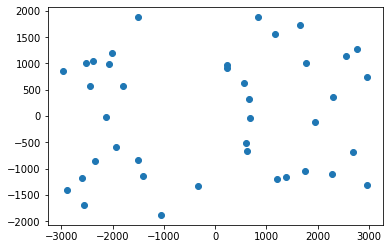

In [16]:
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T   
    return rotcoords 
#print rotate(254,coords)[:,0]
plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [17]:
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [18]:
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [19]:
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model):
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) 
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                total_att[j,:] = total_att[j,:]* \
                    att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att

In [20]:
def power(wsr,v):
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel)
    return power_vec

In [21]:
#talked about
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [22]:
def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [23]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [24]:
wind_dist(1.0,v0)

0.024244336764100854

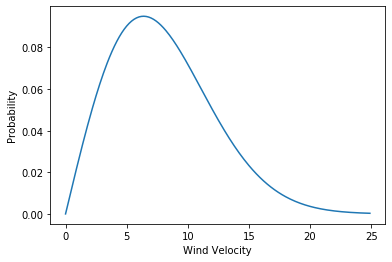

In [25]:
x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [26]:
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)
wsp=windspeedprobability(angles,velocities,dang,dvel)
print(wsp,np.shape(wsp),np.sum(wsp))
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532


In [27]:
#cubic Based Power output
#constants RENAME!!!
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v):

    if (v<Vc): 
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr
    elif (v<Vf):
        q=Pr
    else: 
        q=0
    return q

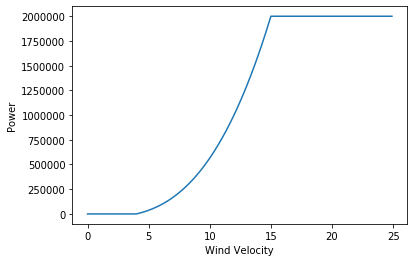

In [28]:
x=np.arange(0,25,0.1)
POvec=np.vectorize(q)
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [29]:
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)
#print(powout,np.shape(powout))

In [30]:
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))

[736160.07815346 794965.33663735 826713.65567389 587541.84135349
 663686.21263759 780430.38551347 524381.9523905  770269.75479192
 766870.64892408 792042.4310281  351284.43468657 812412.08271788
 516542.80259723 756707.07124048 749615.12890705 776404.76896432
 794285.72062299 807897.39920124 349822.98461156 503480.64715076
 589742.22778103 702209.99965547 750491.21326082 694072.23918688
 752394.88571605 787944.26320452 760086.2364792  735519.45923144
 548443.62936025 571510.26677455 762403.47993849 771068.28273599
 781558.17091705 752594.58283585 803304.27774644 746461.712715
 660733.52599504 749650.63611663 615396.61917499 761835.98797054] (40,) 27958937.034600146


In [31]:
#Reference output:
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078] (40,) 34686426.403231286


In [32]:
dvel=0.1
dang=0.1
velocities=np.arange(Vc,Vf+dvel,dvel)
angles=np.arange(0,360,dang)
wsp=windspeedprobability(angles,velocities,dang,dvel)
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print (dvel,dang,np.sum(output))
fineout=output

0.1 0.1 28193344.198355608


In [33]:
velarray=np.array([1.5])
angarray=np.array([5])
rmserror=np.zeros((np.size(velarray),np.size(angarray)))
i=0
for dvel in velarray:
    j=0
    for dang in angarray:
        velocities=np.arange(Vc,Vf+dvel,dvel)
        angles=np.arange(0,360,dang)
        wsp=windspeedprobability(angles,velocities,dang,dvel)
        wsr=windspeedreduction(distance,angle,angles,model)
        powout=power(wsr,velocities)
        output=np.zeros((nturb)) 
        output=np.tensordot(powout,wsp,2)
        rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
        print (dvel,dang,np.sum(output),rmserror[i,j])
        j+=1
    i+=1
print(rmserror)

1.5 5 28329380.34105368 3444.792808428693
[[3444.79280843]]


In [34]:
def geom_analysis(coords):
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    nturb=np.size(coords,0)
    distance=np.zeros((nturb,nturb))
    angle=np.zeros((nturb,nturb))
    for i in range(0,nturb):
        distance[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1]))
        angle[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0])
        distance[i,i]=1e10
#Rotate angles so that north=0 and convert to degrees
    angle=-np.rad2deg(angle)+270
    return distance,angle

In [35]:
#I added this bit
def Minimum_Spanning_Tree(distance):
#    edges= np.zeros((0,3))
    g=Graph(nturb)
    for i in range(0,nturb):
        for j in range(i+1,nturb):
#            if distance[i,j]<1500:
            g.addEdge(i,j,int(distance[i,j]*1000))
#    for p in range(0,(edges.shape[1]-1)):
#        if int(edges[p,2])<1500:
#            g.addEdge(int(edges[p,0]),int(edges[p,1]),int(edges[p,2]))
    MSTweight=g.boruvkaMST()
#    print (MSTweight)
    return MSTweight

In [36]:
def targetfunction(coord_flat):
#from scipy.optimize import minimize
    coords=np.reshape(coord_flat,(-1,2))
    nturb=np.size(coords,0)
#    print(coords)
    distance,angle = geom_analysis(coords)
    MSTweight=Minimum_Spanning_Tree(distance)###
    CableCost=(MSTweight[0]/1000)*300###
    coords_in = np.loadtxt('start_coords.txt')###
    TurbineCost=(nturb)*3000000/1.2821###
    MaintenanceCosts=(nturb)*2*1563720###
    FixedCost=600000###
    xmin = min(coords[:,0])###
    ymin = min(coords[:,1])###
    xmax = max(coords[:,0])###
    ymax = max(coords[:,1])###
    LandCost=((abs(xmin)+abs(xmax))*(abs(ymin)+abs(ymax)))*(17245/10000)###
    TotalCost=CableCost+TurbineCost+LandCost+MaintenanceCosts+FixedCost###
    penalty=0
    wsr=windspeedreduction(distance,angle,angles,model)
    powout=power(wsr,velocities)
    output=np.tensordot(powout,wsp,2)
    
    print(np.min(distance),np.sum(output),TotalCost,(TotalCost/(np.sum(output))))###

    #if(np.min(distance)<200): penalty=10000*nturb*(np.min(distance)-200)**2
    return (TotalCost/(np.sum(output)))#+penalty

In [37]:
flat_coords=coords.flatten()
bounds=Bounds(np.tile([-2728.5, -1952.],nturb), np.tile([2728.5, 1952.],nturb))
dvel=1.5
dang=5
velocities=np.arange(Vc,Vf+dvel,dvel)
angles=np.arange(0,360,dang)
#MSTweight=Minimum_Spanning_Tree(distance)
res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, hess=None, options={'disp': 2, 'eps': 50}, bounds=bounds)

44.91102314577124 27856338.719452735 260398700.68215328 9.347915506940284
44.91102314577124 27858596.63286572 260403267.88215327 9.34732180927401
44.91102314577124 27826082.651341837 260398527.28215325 9.358073522059213
44.91102314577124 27860323.742050417 260736555.23215327 9.358705148088994
44.91102314577124 27854764.53679614 260391617.38215327 9.348189500513493
44.91102314577124 27872781.62662389 260407241.68215328 9.342707346919909
44.91102314577124 27804361.939897336 260386224.58215326 9.36494155647273
44.91102314577124 27674790.517391328 260395400.98215327 9.409119133838292
44.91102314577124 27842754.36407224 260388083.98215327 9.352095003867616
44.91102314577124 27964652.52720411 260735032.73215327 9.323735829669591
44.91102314577124 27950050.13985084 260408979.58215326 9.31694141080861
44.91102314577124 27854421.527835164 260390234.08215326 9.348254955571166
44.91102314577124 27855617.01877358 260393794.48215327 9.34798156891151
44.91102314577124 27915977.810764514 260405185.78

44.9120862250395 27924158.659846213 260400812.3061815 9.325287665000525
44.9120862250395 27729412.998839296 260377137.20618147 9.38992604052168
44.9120862250395 27802899.35282293 260401978.40618145 9.366000829684761
73.6010387000529 27907131.89427185 260396459.00618148 9.330821239270017
10.81621657075964 27823633.73775474 260398833.20618147 9.358908173551693
44.9120862250395 27940489.99684386 260398591.40618145 9.319757507316297
44.9120862250395 27935403.89615245 260407814.60618147 9.321784484456568
44.9120862250395 27867447.86682882 260403558.20618147 9.344363339283214
44.9120862250395 27700519.165583782 260396278.10618147 9.400411470616337
44.9120862250395 27846943.696140192 260406718.10618147 9.351357224249924
44.9120862250395 27891499.53784979 260403631.10618147 9.33630803007935
44.9120862250395 27860274.657863572 260378487.8061815 9.345869378667075
44.9120862250395 27857129.406516016 260396364.8061815 9.34756632696234
44.9120862250395 27875710.260669544 260405040.8061815 9.3416468

229.54757288415274 30251083.581101917 258914902.81790036 8.558863755202688
229.54757288415274 30290259.515892826 258922499.71790034 8.548044944350766
229.54757288415274 30205462.8144838 258901543.21790034 8.571348328877605
229.54757288415274 30251430.233073507 258906059.11790037 8.558473339050318
229.54757288415274 30249759.72512382 258648553.57538122 8.550433323295513
229.54757288415274 30253533.023125246 258910066.81790036 8.558010947679872
229.54757288415274 30240929.94972033 258910270.51790035 8.561584281580426
229.54757288415274 30243492.343545057 258906345.01790035 8.560729100889017
229.54757288415274 30261264.741169564 258912051.91790035 8.555889984520643
229.54757288415274 30255072.256762005 258899260.51790035 8.557218383771547
229.54757288415274 30254401.692852292 258896809.81790036 8.557327044383946
229.54757288415274 30263976.84733723 258915071.11790037 8.555223010642798
229.54757288415274 30263624.146783948 258907141.21790034 8.55506068811041
229.54757288415274 30262373.930

367.3177479915732 31014589.51157482 258353816.43468574 8.330073700903462
367.3177479915732 31007820.38914685 257979790.38807765 8.319829873575184
367.3177479915732 31011818.61825724 257983939.68807763 8.31889102873179
367.3177479915732 31011833.311080053 257971839.48807764 8.318496907305
367.3177479915732 31016770.989074323 257986749.78807765 8.317653371427788
336.25505629485366 30986201.767610252 257967273.48807764 8.325230546898773
373.4057534754 31008680.676726818 257978490.48807764 8.319557132325858
355.7750591168867 30998729.870918967 257970151.08807766 8.321958743544807
344.53500498671013 30989000.999585733 257983919.28807765 8.325015681903603
367.3177479915732 31013655.53368084 257992667.58807766 8.318679728286062
367.3177479915732 31014322.065929033 258468084.8787558 8.333829910236776
367.3177479915732 31016310.57129258 257980783.98807764 8.31758449784334
367.3177479915732 31009214.322948635 257971993.38807765 8.319204437152194
367.3177479915732 31007809.078761354 257984792.588

341.55573370696237 30988740.54510473 255362381.0995658 8.240489177928376
341.55573370696237 30988929.55994787 255363479.69956583 8.24047436700151
341.55573370696237 30983145.872690976 255364408.49956584 8.242042610806928
341.55573370696237 30989756.851548664 255362929.79956582 8.240236637636105
341.55573370696237 30988410.227191433 255353958.5995658 8.240305221450182
341.55573370696237 30998928.947091524 255363254.99956584 8.23780897189757
341.55573370696237 30999440.679252848 255364911.29956582 8.23772641389866
341.55573370696237 30994407.64354881 255372050.69956583 8.239294444225944
341.55573370696237 30992423.31211629 255370483.19956583 8.239771399215831
341.55573370696237 30977050.386387974 255348264.29956582 8.243143266208834
341.55573370696237 30996852.499890957 255362996.99956584 8.23835249080416
341.55573370696237 30998402.46513615 255361084.19956583 8.237878854781952
341.55573370696237 30994940.434381846 255369745.49956584 8.239078440566741
337.04943059622263 30969261.08189279

381.96006468873685 31010757.078250922 255328715.13969666 8.233553102086915
381.96006468873685 31014864.090861484 255087120.9804249 8.224673183578005
381.96006468873685 31005209.525869537 254862673.68083334 8.219995206553461
315.3703198008997 30975803.352896176 253801707.60120627 8.193547224901153
315.3703198008997 30976661.11167032 253808181.60120627 8.193529337659479
315.3703198008997 30974529.71587522 253788065.70120627 8.1934437109834
315.3703198008997 30980290.876857057 253959848.2050571 8.197464937127837
315.3703198008997 30959463.285192326 253787751.90120625 8.197420916614888
315.3703198008997 30976325.489700794 253816676.40120625 8.193892348064228
315.3703198008997 30973497.47209008 253803527.70120627 8.194215972216446
315.3703198008997 30974310.57602652 253804624.20120627 8.194036266868384
315.3703198008997 30968793.87944603 253778994.00120628 8.194668316406059
315.3703198008997 30977597.654669534 254085916.73004732 8.202247300211372
315.3703198008997 30979060.259119146 2542562

356.92636588932265 30991349.74005245 253150962.60792482 8.168439410715914
356.92636588932265 30989055.24144114 253125219.0079248 8.16821348814225
356.92636588932265 30991922.167814083 253128210.90792483 8.167554420706601
351.5272934863994 30977340.501797654 253123155.90792483 8.171235871369777
356.92636588932265 30998451.406077743 253119409.2079248 8.165550139652998
356.92636588932265 30980266.289235808 253120158.0079248 8.170367408877702
356.92636588932265 30980939.195426032 253133260.8079248 8.170612879460315
356.92636588932265 30971558.979377225 253106271.90792483 8.172216066890872
356.92636588932265 30986107.846786246 253134241.5079248 8.169281626449218
356.92636588932265 30983130.71447421 253119431.10792482 8.169588588078883
356.92636588932265 30986544.353085328 253118205.90792483 8.16864904403972
335.9122077230478 30986133.63532813 253134454.8079248 8.169281711201277
329.176837621149 30962184.01457658 253130059.2079248 8.175458781872576
356.92636588932265 30991663.711984005 25314

223.72522248504987 30401609.16127074 253619027.85047328 8.342289597406047
223.72522248504987 30400657.619399987 253628076.15047327 8.34284834643255
223.72522248504987 30408506.968284015 253636342.35047328 8.340966645123855
223.72522248504987 30404257.21970295 253616917.35047328 8.341493611168413
223.72522248504987 30408584.821132313 253638206.25047326 8.341006585555027
223.72522248504987 30392598.2245806 253632909.45047325 8.345219700411883
223.72522248504987 30405541.12039997 253625233.35047328 8.34141488704862
223.72522248504987 30402337.573182635 253625560.95047325 8.34230461193852
223.72522248504987 30403390.44333923 253633827.45047325 8.342287611743622
223.72522248504987 30406686.762379333 253614926.85047328 8.340761649975567
223.72522248504987 30404035.36274971 253625162.25047326 8.341825656511658
223.72522248504987 30401854.103482973 253624833.75047326 8.342413357000384
223.72522248504987 30403135.117431693 253620386.25047326 8.341915571235269
223.72522248504987 30399779.8419997

306.0900847506747 30902071.222210035 252477856.45277756 8.170256764903055
302.1223535161625 30907382.246898487 252513485.95277756 8.170005597226433
306.0900847506747 30953533.382689144 252512070.85277754 8.157778555710724
306.0900847506747 30909797.236316696 252515137.75277758 8.169420712216487
306.0900847506747 30904196.74000092 252494797.45277756 8.17024301188066
306.0900847506747 30906908.146006487 252507794.95277756 8.169946788592128
306.0900847506747 30905587.98807956 252498334.75277758 8.169989674688198
306.0900847506747 30900117.016140927 252507155.05277756 8.171721644965888
306.0900847506747 30897141.98251772 252501738.55277756 8.172333178766133
306.0900847506747 30906205.1251544 252514657.15277755 8.170354662768261
306.0900847506747 30910317.464553475 252496541.05277756 8.168681584792163
306.0900847506747 30905674.946879067 252496484.05277756 8.169906804713717
306.0900847506747 30909118.008750305 252506411.05277756 8.169317900992631
306.0900847506747 30914501.222813815 2524975

345.93210178905224 30987978.629079 252245739.19614702 8.140115953205177
332.1467813874981 30955191.15000828 252222422.59614703 8.147984658659734
345.93210178905224 30975114.199860014 252233319.19614702 8.143095698329562
345.93210178905224 30962788.708449014 252219658.69614702 8.145896064824491
345.93210178905224 30965905.26219749 252216950.59614703 8.144988769440177
335.33383159678374 30952301.596719712 252232050.19614702 8.149056360412251
345.93210178905224 30978602.204626746 252224942.29614702 8.141908425373579
345.93210178905224 30977045.357744984 252215077.09614703 8.141999153998958
345.93210178905224 30989817.72646203 252510657.47600222 8.148181435103595
345.93210178905224 30987944.14679044 252226966.396147 8.139519201446324
345.93210178905224 30975576.86660536 252217829.896147 8.142474020171099
345.93210178905224 30974613.767419815 252229279.09614703 8.14309682729444
345.93210178905224 30970227.508451816 252236533.996147 8.144484373817123
345.93210178905224 30984820.83881079 2522

196.07410575837582 29919945.41456508 254942137.5320016 8.520808911900467
196.07410575837582 29895795.728210263 254627064.78884876 8.517152950325308
196.07410575837582 29868049.72849607 254626314.78884876 8.525039870478006
196.07410575837582 29896936.994404424 254618704.38884875 8.516548181390748
196.07410575837582 29894563.674475893 254623652.58884877 8.517389829183141
196.07410575837582 29898004.533265576 254632182.78884876 8.516694902013812
196.07410575837582 29895821.88900769 254626855.08884877 8.517138482901913
196.07410575837582 29854203.274316765 254618055.18884876 8.528717140741579
333.83527894916676 30955493.269481305 252023071.6291699 8.14146521378927
333.83527894916676 30957190.90567575 252021336.7291699 8.140962708698606
333.83527894916676 30954476.06746263 252029075.8291699 8.141926721030396
333.83527894916676 30957993.80366468 252023155.0291699 8.140810306620594
333.83527894916676 30950283.70281788 252008086.9291699 8.142351435254396
333.83527894916676 30953935.223708525 2

356.70827150594727 30951211.476109184 252583842.3316543 8.160709396678069
350.6127154564572 30926125.66629444 252582998.73165432 8.167301700094228
356.70827150594727 30953544.607020736 252595324.23165432 8.160465220980276
356.70827150594727 30950944.194409054 252612597.63165432 8.161708930265398
322.7346027894919 30920397.20544689 252583316.13165432 8.168825078584684
356.70827150594727 30959525.17179595 252600743.13165432 8.15906386580415
356.70827150594727 30956017.195175737 252593812.23165432 8.159764566580586
356.70827150594727 30959047.10364659 252603708.3316543 8.159285635826327
356.70827150594727 30950789.35404621 252596103.3316543 8.161216841425478
356.70827150594727 30950902.251862325 252591675.9316543 8.161044026316093
356.70827150594727 30948689.373864904 252591621.63165432 8.161625798763524
356.70827150594727 30952956.999998026 252600370.8316543 8.160783179186092
309.32728954259795 30908305.91711376 252575276.73165432 8.171760607293743
345.15820032217044 30946045.529610973 2

346.2542601728385 30970377.473019853 251987402.61281952 8.136400753666654
346.2542601728385 30986469.711540524 252245126.58000225 8.140492573959037
346.2542601728385 30976481.143194523 251991753.51281953 8.134937998539632
346.2542601728385 30974691.950648747 251988332.91281953 8.135297465243776
346.2542601728385 30980310.507845044 251995565.01281953 8.134055497894623
346.2542601728385 30976107.91737116 252006191.61281952 8.135502119409146
346.2542601728385 30980299.97307101 252023554.48068434 8.134961724055307
346.2542601728385 30969759.870830078 251996292.51281953 8.13685006160383
346.2542601728385 30977875.196612332 251995511.01281953 8.134693209700101
346.2542601728385 30974042.41011429 251995953.81281954 8.13571410784059
346.2542601728385 30975455.680047832 252007336.11281952 8.135710373912097
346.2542601728385 30979161.890980482 251998763.01281953 8.134460315602936
346.2542601728385 30977391.39854685 251995312.41281953 8.134813844416888
346.2542601728385 30975343.941191312 2519923

369.99832246297206 31007015.779741995 251973451.5340563 8.126336740173484
369.99832246297206 30990892.99448473 251886891.38651744 8.127771324025554
369.99832246297206 30987099.282178238 251857981.60053143 8.127833435038037
369.99832246297206 30988373.705008775 251871536.50053144 8.127936589967625
369.99832246297206 30987368.166115694 251861737.30053145 8.127884109110601
369.99832246297206 30979536.350330137 251870650.00053144 8.130226584164078
369.99832246297206 30985980.772743586 251863526.80053145 8.128305786017911
369.99832246297206 30987974.97188111 251878386.70053142 8.128262234918195
369.99832246297206 30991858.011016183 251859866.50053144 8.126646244023409
369.99832246297206 30984992.10636321 251859031.9005314 8.128420076273267
369.99832246297206 30991123.62412463 251872121.50053144 8.127234254406474
369.99832246297206 30992317.46332123 251862773.20053142 8.126619556559648
369.99832246297206 30993672.01990603 252102155.0892579 8.133987961392329
369.99832246297206 30986252.147805

205.27799975752555 30346291.50527461 251611100.36289632 8.291329446933007
205.27799975752555 30350480.522275697 251629374.5628963 8.29078717149843
205.27799975752555 30342183.70628743 251623584.5628963 8.292863394362598
205.27799975752555 30351211.30672896 251606387.36289632 8.289830175809636
182.54424174381202 30268356.691686757 251610148.16289634 8.31264646197332
248.52717556639425 30452486.14423738 251615112.5628963 8.262547477113301
205.27799975752555 30330527.594089597 251614037.96289632 8.295735614303243
205.27799975752555 30304130.65788748 251602753.46289632 8.30258938305527
205.27799975752555 30331499.74980554 251615965.7628963 8.295533285145567
205.27799975752555 30275237.012652736 251617617.86289632 8.311004064402184
205.27799975752555 30320857.548915792 251606116.16289634 8.298120056696524
205.27799975752555 30298994.256805707 251605748.66289634 8.30409572444409
205.27799975752555 30336692.381141543 251614415.0628963 8.294062249822248
205.27799975752555 30338650.806422047 25

351.07421831842197 30965583.044941664 251777242.27852935 8.130873619047133
376.2151755834395 30963209.11740405 251758840.27852935 8.130902689186009
376.2151755834395 30970423.748197395 251771969.47852936 8.129432503912172
376.2151755834395 30967618.066603415 251771778.37852937 8.13016286357681
376.2151755834395 30972206.59968759 251826336.09542865 8.130719885420394
376.2151755834395 30972950.532254986 251793192.72938377 8.129454520878413
329.9556469068202 30943603.509111457 251773727.47852936 8.136535468611266
371.1533647359864 30987667.96940725 251831010.63668707 8.126813895298886
371.1533647359864 30988876.808184057 251824653.33668706 8.126291730269521
371.1533647359864 30986431.442918003 251845866.03668708 8.127617615491726
371.1533647359864 30990872.56955214 251829965.43668705 8.125939818942193
371.1533647359864 30982669.75897587 251690892.55864704 8.123602469271733
371.1533647359864 30985945.14196562 251836053.03668708 8.127428480327827
371.1533647359864 30985034.21925735 25183228

347.35101469045344 30956659.22112719 251787471.8563219 8.133547940615081
374.28209704005945 30983718.996593066 252141314.14639473 8.137864733866193
374.28209704005945 30980226.296240535 251788722.2563219 8.127401002454155
374.28209704005945 30984035.69305672 251799310.7563219 8.126743502711241
374.28209704005945 30976286.623401992 251796871.4563219 8.128697752496072
374.28209704005945 30976153.208506517 251792284.15632188 8.128584671616872
374.28209704005945 30974655.161024213 251786594.9563219 8.128794126920516
374.28209704005945 30978888.37203203 251795414.3563219 8.127968032050003
326.6410499510495 30942531.73797969 251770140.2563219 8.136701365883791
363.2857340345139 30974093.307530157 251795353.7563219 8.129224357153582
374.28209704005945 30971016.825597197 251780685.2563219 8.129558247123098
374.28209704005945 30978182.022624657 251785268.9563219 8.127825860550262
372.02826925652244 30972088.45114623 251782019.0563219 8.129320031274927
374.28209704005945 30979959.859127067 25178

371.7572230828853 30989842.91001072 251823625.11381114 8.126005215485103
371.7572230828853 30985044.873747386 251821997.0138111 8.127210983230547
371.7572230828853 30991429.796537306 251885263.53903306 8.127578017300008
361.2346246689281 30965927.599860176 251824273.71381113 8.132301960008077
371.7572230828853 30986440.862803303 251823321.81381112 8.126887593473327
371.7572230828853 30982851.54243388 251823802.71381113 8.127844603616138
371.7572230828853 30984869.656966757 251836626.81381112 8.127729101393435
371.7572230828853 30988807.924645104 251816774.0138111 8.12605553031111
371.7572230828853 30985189.555107318 251823191.0138111 8.127211568802647
371.7572230828853 30983088.875998802 251821213.41381115 8.127698772115831
371.7572230828853 30984055.83256731 251810485.41381115 8.127098878679833
371.7572230828853 30980208.39539587 251811000.5138111 8.12812481116925
371.7572230828853 30996759.204834618 252109313.13173792 8.133408769146937
336.598945241704 30973882.31173481 251827498.713

377.79168038745945 30979754.941757295 251772368.1703381 8.126996764295791
377.79168038745945 30976864.061211716 251676321.52366856 8.12465461404823
377.79168038745945 30977142.09677249 251687954.32366857 8.124957219662042
377.79168038745945 30976106.59701766 251677819.72366858 8.124901653970282
377.79168038745945 30966305.476439275 251686995.82366857 8.127769585401937
377.79168038745945 30979368.482346244 251677708.12366855 8.124042562942767
377.79168038745945 30977158.36528527 251695373.02366856 8.125192441981135
377.79168038745945 30981495.781465977 251677162.42366856 8.12346712369611
377.79168038745945 30971283.73428329 251674716.82366857 8.126066681087561
377.79168038745945 30978566.584749423 251691006.52366856 8.124682135795613
377.79168038745945 30980610.472350705 251680277.32366857 8.12379980531003
377.79168038745945 30982176.215140477 251938578.8034864 8.131726353049666
377.79168038745945 30975560.14706113 251666902.42366856 8.124692539177406
348.50945543844796 30949751.7564966

295.9763454045394 30585041.299091604 251046308.88855666 8.208140261560246
295.9763454045394 30589364.54551131 251027124.48855662 8.206353032115942
295.9763454045394 30578441.181521162 251036460.48855662 8.209589854444912
295.9763454045394 30615573.410627514 251036911.98855662 8.199647565686774
295.9763454045394 30575607.587876286 251033089.08855665 8.21024041360654
295.9763454045394 30559406.85364187 251022946.08855665 8.214261071583637
296.07396913655793 30579853.384384684 251038041.78855664 8.209262439327027
246.18142048018714 30490755.685405914 251037099.18855664 8.23321998899204
295.9763454045394 30565014.46707809 251024471.28855664 8.212803941543617
295.9763454045394 30566779.452054396 251033681.28855664 8.212631025859828
295.9763454045394 30581130.818106458 251041717.08855665 8.209039704310738
295.9763454045394 30582890.04477887 251043933.78855664 8.208639975521706
295.9763454045394 30579839.535002984 251044101.78855664 8.209464327018487
295.9763454045394 30577955.30093149 251060

371.7052565179576 30962035.22787045 251569243.3278852 8.125087432929323
371.7052565179576 30961952.09269572 251609962.17674524 8.126424374776516
334.98661554805227 30939407.21146508 251558795.5278852 8.13069215607551
378.8538808562066 30975586.03330736 251657040.58347398 8.124367374772918
378.8538808562066 30976599.460690074 251646246.28347397 8.123753112500877
378.8538808562066 30974543.76518118 251667458.68347397 8.124977097043672
378.8538808562066 30978479.75220824 251655723.88347396 8.123565968905726
378.8538808562066 30970046.69723332 251518869.41870147 8.121359062760815
378.8538808562066 30973129.346216656 251646404.38347396 8.124668372077565
378.8538808562066 30973339.109443974 251655941.38347396 8.124921258707378
378.8538808562066 30977299.92126061 251663299.78347397 8.124119933730901
378.8538808562066 30971928.19083921 251634756.58347398 8.124607387469721
378.8538808562066 30988842.31223286 251669569.48347396 8.121296270049019
378.8538808562066 30987037.621080875 251707749.671

375.5434489992401 30971133.088289276 251600099.30107433 8.123696946567598
375.5434489992401 30964250.65762593 251597273.00107434 8.125411326209845
375.5434489992401 30960765.397636224 251594624.30107433 8.12624045529194
375.5434489992401 30962571.9320976 251587538.90107435 8.125537486124145
375.5434489992401 30967038.916073516 251595047.30107433 8.124607844584176
332.8745723655733 30932000.17475856 251570193.50107434 8.13300763221782
374.8274550824035 30958204.8993216 251585850.80107433 8.12662916403746
375.5434489992401 30959575.897626426 251579783.00107434 8.126073297417559
375.5434489992401 30966623.166509107 251587060.10107434 8.124458994068481
375.5434489992401 30962182.88979047 251578617.80107433 8.125351455243498
375.5434489992401 30968807.860015314 251583664.70107433 8.123776215031544
375.5434489992401 30981365.950852584 251602757.90107435 8.121099576442349
375.5434489992401 30961570.303262293 251591314.70107433 8.125922304223865
375.5434489992401 30967287.593109958 251599324.1

334.7538616129883 30943987.619097795 251647800.206365 8.132364946108456
379.42206493021155 30974104.62414314 251644495.706365 8.12435092991252
379.42206493021155 30970870.524104405 251644933.706365 8.125213448892616
379.42206493021155 30972085.86433982 251658169.40636498 8.125321959542783
379.42206493021155 30975827.640783448 251638639.40636498 8.123709956180544
379.42206493021155 30972909.938347135 251644415.90636498 8.124661725594194
379.42206493021155 30970721.034857757 251643598.40636498 8.1252095526978
379.42206493021155 30971657.833425637 251630620.706365 8.124544771213277
379.42206493021155 30967136.72143527 251631391.106365 8.125755809131272
379.42206493021155 30983921.16128946 251936195.42675707 8.131191469126247
368.71300803685244 30974079.766217135 251647594.706365 8.124457501424544
379.42206493021155 30964534.860139754 251629605.206365 8.126380917489076
379.42206493021155 30973013.970479604 251643331.706365 8.124599431821727
379.42206493021155 30971022.467020538 251642649.2

379.7226283977646 30971219.631366596 251634567.41326225 8.124787154278398
379.7226283977646 30960943.150270514 251643862.91326225 8.127784147010507
379.7226283977646 30974675.918170206 251633776.91326225 8.123855034933557
379.7226283977646 30972331.67986718 251652442.91326225 8.125072581372454
379.7226283977646 30976913.73771704 251634304.61326227 8.123285190508698
379.7226283977646 30965951.921695217 251631367.61326227 8.126065953004515
379.7226283977646 30973696.861404493 251648758.31326225 8.124595505641276
379.7226283977646 30975860.633100342 251637568.31326225 8.123666725319849
379.7226283977646 30977384.81766022 251899705.13982356 8.131729215444146
379.7226283977646 30970880.48850411 251623952.81326225 8.124533395382834
346.70331088027683 30944496.12020172 251623219.31326225 8.131436955245595
379.7226283977646 30973360.539850406 251635581.71326226 8.12425830866842
379.7226283977646 30970750.823343933 251652733.31326225 8.125496690367003
342.03512156242056 30949427.663795322 25163

379.4846246209328 30967454.521518663 251628761.5321412 8.125587505336915
379.4846246209328 30975217.06516026 251769524.38099962 8.12809556270004
374.1846746609193 30961397.209800582 251642549.83214122 8.127622539995896
379.4846246209328 30972684.86414031 251635830.43214118 8.124443571357329
379.4846246209328 30964839.643948816 251643497.83214122 8.1267495884261
379.4846246209328 30973753.687961765 251649242.5321412 8.12459623290499
379.4846246209328 30977979.730989575 251650726.6321412 8.123535776621233
379.4846246209328 30976328.06679751 251657552.5321412 8.124189283812646
379.4846246209328 30970313.36892388 251647074.1321412 8.125428733460863
379.4846246209328 30970128.49969431 251636591.2321412 8.125138752156776
379.4846246209328 30979907.9680124 252076451.39165646 8.13677211862386
379.4846246209328 30971360.69909861 251636570.5321412 8.124814824150262
379.4846246209328 30970596.645040374 251636642.5321412 8.125017590593892
379.4846246209328 30977286.627561674 251641440.1321412 8.12

95.29212593322605 27789975.896518253 250133082.07164636 9.000838395940638
95.29212593322605 27596718.678109027 250128823.57164636 9.063716106584074
95.29212593322605 27483258.942404225 250119183.67164636 9.10078328759384
95.29212593322605 27809050.05669047 250141590.07164636 8.99497068622327
95.29212593322605 27590304.843207106 250117727.47164637 9.065420947432077
95.29212593322605 27635637.03097403 250145285.77164638 9.051547662580873
95.29212593322605 27630294.36733543 250118873.77164638 9.05234198544541
95.29212593322605 27734193.301117413 250147743.97164637 9.019470703752825
95.29212593322605 27651771.088852525 250132877.17164636 9.045817584989498
95.29212593322605 27698165.871518932 250142231.47164637 9.031003447374795
95.29212593322605 27746240.30672373 250132031.77164638 9.014988301353105
95.29212593322605 27630922.894544 250132129.27164638 9.05261580390561
95.29212593322605 27630600.71968628 250129454.17164636 9.052624541508207
95.29212593322605 27548624.618391506 250132046.771

368.404759239561 30937700.200551093 251266683.37815553 8.121698825359996
368.404759239561 30941461.577336546 251265824.47815555 8.12068375794498
368.404759239561 30948437.32646674 251274898.87815553 8.119146573622578
368.404759239561 30942761.167283226 251264796.37815553 8.120309464942833
368.404759239561 30951627.990792852 251269949.77815554 8.118149709375563
368.404759239561 30959448.747295395 251284231.57815552 8.1165602666006
368.404759239561 30944111.367553882 251278008.07815552 8.12038210092633
368.404759239561 30948958.771740455 251286639.37815553 8.119389128128141
368.404759239561 30949399.230307322 251269783.87815553 8.118728961694952
357.849956188367 30947198.43050228 251274164.47815555 8.11944787320373
384.0363423330948 30957733.620449908 251279518.87815553 8.11685771183736
368.404759239561 30947120.801949855 251276129.47815555 8.119531735641257
368.404759239561 30938952.866746843 251265386.77815554 8.121328083091504
368.404759239561 30947834.517196894 251362335.4227649 8.12

197.21814593748454 30026797.398238167 249758788.34753457 8.317863041970279
197.21814593748454 29991681.413296852 249734794.9475346 8.326802072417799
190.7827382501677 29924243.732232075 249976761.1401373 8.35365342486105
190.7827382501677 29897883.76975503 249747059.54753458 8.35333568993873
190.7827382501677 29858020.76556283 249729249.4475346 8.363891612519854
190.7827382501677 29902339.32596027 249730603.64753458 8.351540691357426
190.7827382501677 29895902.611764155 249737826.4475346 8.353580411693667
190.7827382501677 29901566.695604138 249739949.84753457 8.352069053433548
190.7827382501677 29912053.13822864 249739821.4475346 8.34913672737357
190.7827382501677 29933334.11870514 249737624.24753457 8.343127539924636
359.04467493317975 30906614.278890625 250991135.58858293 8.120952147127003
359.04467493317975 30908498.557591517 250980762.18858296 8.120121452063835
359.04467493317975 30906158.04148221 251001947.88858294 8.121421871708817
359.04467493317975 30908942.575001664 250989587

106.21195655461861 25029117.480177566 250791388.7132942 10.019985279621412
106.21195655461861 25022991.529217526 250776624.8132942 10.021848287822845
106.21195655461861 25070912.043958753 250795773.51329422 10.003456319162014
106.21195655461861 24864791.83728008 250779836.01329422 10.085740417794169
106.21195655461861 24878238.047340307 250779439.11329418 10.080273315018971
106.21195655461861 25062852.429683432 250777312.7132942 10.005936611440271
106.21195655461861 25060820.237805262 250797295.4132942 10.00754536497398
106.21195655461861 24907101.391425587 250785868.7132942 10.068850034859082
106.21195655461861 25047247.426256113 250793713.7132942 10.012825339458113
106.21195655461861 25195869.04208295 250801514.9132942 9.954072808300339
106.21195655461861 25217692.62361205 250803701.61329418 9.945545191492242
106.21195655461861 25160569.07647576 250789170.51329422 9.967547623864087
93.78651642163832 24922091.494957186 250788834.8132942 10.062912852400032
106.21195655461861 24949927.5

311.76428325740136 30742108.286020897 250341428.3898676 8.143274562067147
351.3525596540302 30772573.441570073 250329340.7898676 8.134819834460206
351.3525596540302 30769009.664105903 250339277.0898676 8.136084970648406
351.3525596540302 30783787.588559188 250346039.3898676 8.132398869686485
351.3525596540302 30786031.81813693 250348165.48986763 8.131875097406363
351.3525596540302 30783409.825774103 250354858.48986763 8.132785156251677
351.3525596540302 30780817.343585722 250356340.18986762 8.133518268709595
351.3525596540302 30779243.81626662 250323853.18986762 8.132878594553814
351.3525596540302 30783935.969870873 250763376.94748205 8.145916662278385
351.3525596540302 30779301.45327813 250334578.7898676 8.133211832954249
351.3525596540302 30779396.704571426 250348616.3898676 8.133642734871579
351.3525596540302 30775211.41315227 250350836.68986762 8.134821019714465
351.3525596540302 30776360.069165766 250335599.0898676 8.134022299169613
356.03125543919003 30791567.875159748 250438913.

358.6677562424312 30905566.519405723 250965066.79914343 8.120383965185091
358.6677562424312 30890999.530777745 250850511.9118568 8.120504862975572
358.6677562424312 30891629.034842428 250952854.09914345 8.123652327175614
358.6677562424312 30898736.54294163 250961753.59914345 8.122071698639472
358.6677562424312 30905437.1314564 250974387.79914343 8.12071955920322
358.6677562424312 30899562.589493886 250945519.39914346 8.121329182972547
358.6677562424312 30921822.152829558 250979821.69914344 8.116592238927197
358.6677562424312 30910152.99958685 250982177.3925931 8.11973261329207
358.6677562424312 30905452.981860455 251143849.43820602 8.126198622152911
358.6677562424312 30903649.887299903 250966458.19914344 8.1209326119851
358.6677562424312 30901245.231619567 250972120.69914344 8.121747807183423
358.6677562424312 30901075.05725956 250961025.49914345 8.12143347874188
358.6677562424312 30890703.230052672 250971251.59914345 8.124491363310264
358.6677562424312 30903146.191108644 250955893.399

358.9674914352015 30908996.51116366 250987588.65284652 8.120211491246415
346.6375262576319 30875635.38502805 250962802.95284653 8.128182621127248
358.9674914352015 30893972.85267839 250971282.7528465 8.123632526953822
358.9674914352015 30901880.61012297 250971857.5528465 8.12157229908629
358.9674914352015 30907888.372741967 250982754.45284653 8.12034621796393
358.9674914352015 30903126.84661673 250977930.15284652 8.121441283224826
358.9674914352015 30913404.05255087 250978074.7528465 8.118745975894448
358.9674914352015 30916597.978078026 250989917.8528465 8.1182903122399
358.9674914352015 30905348.92176632 250993136.5528465 8.121349388036665
358.9674914352015 30908889.964594103 250993927.0528465 8.120444549783512
358.9674914352015 30910072.596241117 250976368.95284653 8.119565820216385
351.08156287216127 30906507.677411683 250982413.3528465 8.120697944021654
377.41397133538976 30920448.439646047 250986041.8528465 8.117154003854402
358.9674914352015 30905343.626427595 250982539.0528465 

359.02900936655215 30906231.218529128 250990121.57112896 8.121019990967179
359.02900936655215 30903456.187591396 250990180.67112893 8.121751144841479
359.02900936655215 30903828.355311207 251004379.67112893 8.122112794093056
359.02900936655215 30909013.68122465 250985818.37112895 8.120149706478262
359.02900936655215 30905847.247772932 250990154.27112895 8.1211219436547
359.02900936655215 30902181.804216057 250991953.07112896 8.122143435091873
359.02900936655215 30909248.177011155 250988209.37112895 8.120165457722203
359.02900936655215 30902542.669046335 250982017.97112894 8.121727090843116
359.02900936655215 30919047.119417753 251277374.57512262 8.12694432673236
359.02900936655215 30916343.895506933 250991052.47112894 8.118393731142492
346.31319077078297 30885189.817846082 250975137.77112895 8.126067518164012
359.02900936655215 30904383.704924643 250976810.87112895 8.121074772674906
359.02900936655215 30904072.509702872 250988229.77112895 8.121526044579621
359.02900936655215 30908259.7

359.0440295236872 30909905.203467596 250987756.41340968 8.119978199908969
359.0440295236872 30896051.487194374 250982729.3134097 8.12345646878002
359.0440295236872 30907009.58659414 251003356.41340968 8.121243684548567
359.0440295236872 30906436.19668671 250991749.41340968 8.121018800618526
359.0440295236872 30909062.918582074 251276569.2424121 8.129543425638708
359.0440295236872 30905248.25609223 250992057.21340966 8.121340917037694
337.7975823518984 30875446.203816153 250976094.21340966 8.128662904388712
359.0440295236872 30906564.54454203 250989010.1134097 8.120896444238845
359.0440295236872 30904273.097406007 251005886.3134097 8.122044661017386
327.53490250082297 30882044.092183366 250988758.71340966 8.12733632411781
359.0440295236872 30915729.942037612 251104970.8675674 8.122239757506998
359.0440295236872 30893052.025138967 250985764.71340966 8.124343444900557
359.0440295236872 30907885.736896537 250998798.51340967 8.120866003260062
359.0440295236872 30905782.406997867 250995781.4

359.0445449335497 30901994.555903025 250980445.763327 8.121820269862926
359.0445449335497 30895008.98695224 250990235.06332698 8.123973524957595
359.0445449335497 30908203.475260243 250996340.66332698 8.120702999261384
359.0445449335497 30910691.213907428 250998198.56332698 8.120109538359245
359.0445449335497 30909019.838086687 251008276.16332698 8.120874666301445
359.0445449335497 30904714.535712518 251004464.963327 8.121882655582342
359.0445449335497 30904096.99215669 250974571.463327 8.121077652811636
359.0445449335497 30909550.56655854 251417009.32165378 8.13395875104264
359.0445449335497 30903768.45213852 250984308.56332698 8.121479066607458
359.0445449335497 30902740.76832995 250998616.463327 8.122212147621479
359.0445449335497 30906830.614593573 251001727.16332698 8.121237997299183
359.0445449335497 30903470.625114 250983667.463327 8.121536590759574
373.55609449531437 30915533.600037053 251104970.4330305 8.122291327125259
310.55010761906846 30864973.063782282 250995914.06332698 

359.04466988878517 30908498.529710777 250980761.91210133 8.120121450443353
359.04466988878517 30906158.019716375 251001947.61210135 8.121421868482532
359.04466988878517 30908942.555914182 250989587.31210133 8.120290328860715
359.04466988878517 30894601.98354317 250874638.1111762 8.120338894309473
359.04466988878517 30895622.71506668 250977356.31210133 8.123395298639142
359.04466988878517 30902262.244265623 250986279.51210135 8.121938695885465
359.04466988878517 30908810.550734848 250998872.61210135 8.12062541844186
359.04466988878517 30902918.03258104 250970010.81210133 8.121239895452685
359.04466988878517 30925037.091480114 251004040.71210134 8.116531597669555
359.04466988878517 30913565.364006057 251007232.54560056 8.119646814917656
359.04466988878517 30908868.748798303 251167243.2276505 8.12605745195432
359.04466988878517 30906938.095191903 250990971.21210134 8.120861744345591
359.04466988878517 30904568.5921293 250996655.31210133 8.12166830816155
359.04466988878517 30904399.0596708

346.5379307451631 30876291.309678987 250967709.89717 8.128168871709589
359.044665967373 30894683.405899487 250976204.09717 8.12360498406159
359.044665967373 30902544.503168847 250976794.79717 8.121557587966066
359.044665967373 30908561.369044244 250987667.39717 8.120328358230898
359.044665967373 30903786.22603617 250982753.99717003 8.121424092227226
359.044665967373 30914042.969271038 250983006.89717 8.118737725332478
359.044665967373 30917294.868766263 250994831.69717002 8.118266257205246
359.044665967373 30906017.50695034 250997949.29717 8.12132942203647
359.044665967373 30909562.75716711 250998846.89717 8.120426965242983
359.044665967373 30910746.751655094 250981299.89717 8.11954825658592
351.11515468128766 30907164.391747132 250987319.99717003 8.120684149989152
377.5112871686582 30921079.742801696 250990972.19717002 8.117147728503877
359.044665967373 30906040.500089057 250987471.79717 8.120984368620327
359.044665967373 30896277.412914563 250976902.49717003 8.123208474049445
359.044

359.04466911626855 30909151.8678554 250986816.16975996 8.12014568509655
359.04466911626855 30905983.88359421 250991154.46975994 8.121118402672607
359.04466911626855 30902320.41540557 250992950.56975996 8.122139282609787
359.04466911626855 30909374.74753155 250989212.26975995 8.12016465295223
359.04466911626855 30902669.73657573 250983018.46975994 8.121726071217138
359.04466911626855 30919176.184126772 251278402.02666754 8.126943632982963
359.04466911626855 30916470.946946494 250992055.36975998 8.118392807525451
346.3461292375004 30885339.144175023 250976137.66975996 8.126060604294645
359.04466911626855 30904519.189311 250977832.36975998 8.121072223526651
359.04466911626855 30904209.342725456 250989229.96975994 8.121522449783699
359.04466911626855 30908397.012613133 250996367.56975996 8.120653020838741
359.04466911626855 30907686.034546684 251033092.7683265 8.122028044666216
337.4231216166896 30892459.001879152 250991238.46975994 8.124676590312621
359.0446685648463 30906614.255404267 25

359.0446672661097 30909068.783297405 251276609.45063803 8.129543183986911
359.0446672661097 30905254.17968498 250992098.16835335 8.121340685602208
337.7985482258687 30875452.502188653 250976135.16835335 8.128662572655818
359.0446672661097 30906570.389141005 250989051.06835335 8.120896233654516
359.0446672661097 30904278.880509418 251005926.96835336 8.12204445665473
327.5357067730245 30882049.651244853 250988800.56835335 8.127336216436529
359.0446672661097 30915735.290980347 251105014.88459095 8.122239775996878
359.0446672661097 30893058.847690597 250985805.66835335 8.124342976387258
359.0446672661097 30907891.67302535 250998839.16835335 8.12086575893531
359.0446672661097 30905788.110806555 250995822.66835335 8.121320892010836
359.0446672661097 30895890.462535374 250992838.86835337 8.123826020574143
359.0446672661097 30903752.774893135 250986826.56835335 8.121564665514034
359.0446672661097 30909636.501721516 250992522.36835337 8.120202977941016
346.5379290738313 30876291.360860754 25096

359.0446671466763 30908204.526164867 250996349.16180724 8.120702998109454
359.0446671466763 30910692.388803206 250998207.06180725 8.120109504655627
359.0446671466763 30909021.05889444 251008284.36180723 8.120874610798344
359.0446671466763 30904715.597969055 251004473.16180724 8.121882641699584
359.0446671466763 30904098.053039882 250974579.66180724 8.121077639317162
359.0446671466763 30909551.757688135 251417017.5957341 8.13395870527948
359.0446671466763 30903769.581145115 250984316.46180725 8.121479025488748
359.0446671466763 30902741.868751537 250998624.36180723 8.122212113987654
359.0446671466763 30906831.798042424 251001734.76180726 8.121237932181234
359.0446671466763 30903471.748315334 250983675.36180723 8.121536551164006
373.5562793003156 30915534.649699956 251104978.21747524 8.122291303149508
310.55024754840366 30864974.162442263 250995921.66180724 8.132063235848392
359.0446671466763 30906369.30182527 250991121.96180725 8.121016076352397
359.0446671466763 30903592.196221933 2509

In [38]:
#print(res.x)
#print(res.x-flat_coords)

In [39]:
newcoords=np.reshape(res.x,(-1,2))
#print(newcoords)

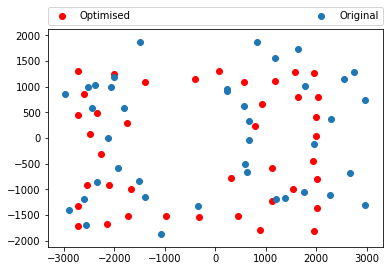

In [40]:
plt.scatter(newcoords[:,0],newcoords[:,1], color='red')
plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

plt.legend(["Optimised", "Original"],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

In [41]:
newcoords_unconstrained=newcoords

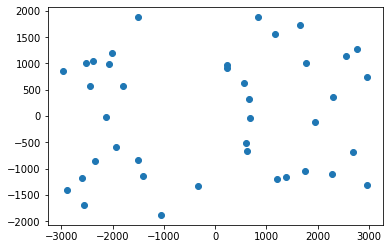

In [42]:
plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

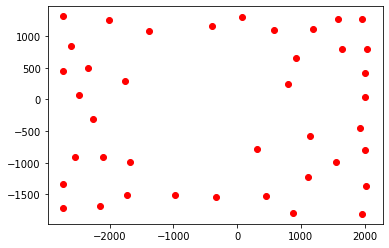

In [43]:
plt.scatter(newcoords[:,0],newcoords[:,1], color='red')

In [44]:
54123077.32294567-53477710.87598161

645366.4469640628

In [45]:
((55751104.56647739-54166276.11371625)/55751104.56647739)*100

2.842685297600504

In [46]:
MSTweight=Minimum_Spanning_Tree(geom_analysis(newcoords)[0])

In [47]:
MSTweight=Minimum_Spanning_Tree(geom_analysis(newcoords)[0])
print (MSTweight)
links=MSTweight[1]
print(links)

[19980572, [[0, 30], [1, 5], [2, 35], [3, 6], [4, 13], [7, 27], [8, 38], [7, 9], [10, 18], [11, 16], [6, 12], [13, 14], [15, 25], [17, 20], [17, 19], [21, 23], [22, 31], [24, 39], [10, 26], [19, 28], [29, 30], [32, 34], [20, 33], [36, 39], [36, 37], [30, 31], [5, 31], [27, 35], [3, 29], [4, 36], [9, 16], [19, 38], [21, 26], [20, 25], [14, 21], [22, 24], [34, 35], [6, 32], [7, 15]]]
[[0, 30], [1, 5], [2, 35], [3, 6], [4, 13], [7, 27], [8, 38], [7, 9], [10, 18], [11, 16], [6, 12], [13, 14], [15, 25], [17, 20], [17, 19], [21, 23], [22, 31], [24, 39], [10, 26], [19, 28], [29, 30], [32, 34], [20, 33], [36, 39], [36, 37], [30, 31], [5, 31], [27, 35], [3, 29], [4, 36], [9, 16], [19, 38], [21, 26], [20, 25], [14, 21], [22, 24], [34, 35], [6, 32], [7, 15]]


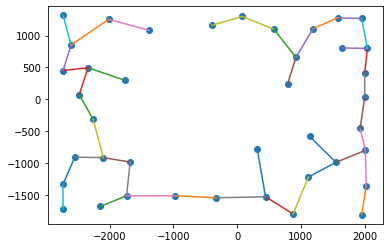

In [48]:
plt.scatter(newcoords[:,0],newcoords[:,1])
plt.axis('equal')
for i in links:
    plt.plot(newcoords[i[:],0],newcoords[i[:],1])

In [49]:
print(MSTweight[0])

19980572


In [50]:
coords_in = np.loadtxt('start_coords.txt')###
print(int(np.shape(coords_in[:,0])[0]))

40


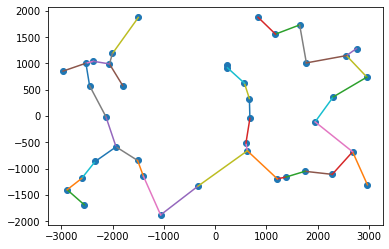

In [51]:
MSTweight=Minimum_Spanning_Tree(geom_analysis(coords)[0])
links=MSTweight[1]
plt.scatter(coords[:,0],coords[:,1])
for i in links:
    plt.plot(coords[i[:],0],coords[i[:],1])#ignore this one

In [52]:
coords=np.loadtxt('start_coords.txt')
nturb=np.size(coords,0)
distance,angle = geom_analysis(coords)
MSTweight=Minimum_Spanning_Tree(distance)###
CableCost=(MSTweight[0]/1000)*300###
TurbineCost=(nturb)*3000000/1.2821###
MaintenanceCosts=(nturb)*2*1563720###
FixedCost=600000###
xmin = min(coords[:,0])###
ymin = min(coords[:,1])###
xmax = max(coords[:,0])###
ymax = max(coords[:,1])###
LandCost=((abs(xmin)+abs(xmax))*(abs(ymin)+abs(ymax)))*(17245/10000)###
TotalCost=CableCost+TurbineCost+LandCost+MaintenanceCosts+FixedCost###
penalty=0
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)
output=np.tensordot(powout,wsp,2)

print(np.min(distance),np.sum(output),TotalCost,(TotalCost/(np.sum(output))))###

44.91102314577124 28329380.34105368 263827389.90415326 9.312854242767404
